##https://tykimos.github.io/2017/04/09/RNN_Layer_Talk/

##One Column

In [16]:
# 0. 사용할 패키지 불러오기
from tensorflow import keras
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import utils
import numpy as np

# 랜덤시드 고정시키기
np.random.seed(5)

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# 데이터셋 생성 함수        
def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)

# 1. 데이터 준비하기

# 코드 사전 정의

code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

# 시퀀스 데이터 정의

seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

# 2. 데이터셋 생성하기
# dataset = seq2dataset(seq, window_size = 4)
dataset = []
window_size = 4
for i in range(len(seq)-window_size):
  subset = seq[i:(i+window_size+1)]
  dataset.append([code2idx[item] for item in subset])
dataset = np.array(dataset)
print(dataset.shape)
# print(dataset)


(50, 5)


In [17]:

# 입력(X)과 출력(Y) 변수로 분리하기
x_train = dataset[:,0:4]
y_train = dataset[:,4]

dataset.shape, x_train.shape, y_train.shape, x_train[4], y_train[4]

((50, 5), (50, 4), (50,), array([8, 1, 7, 8]), 9)

In [18]:
max_idx_value = 13

# 입력값 정규화 시키기
x_train = x_train / float(max_idx_value)

# 라벨값에 대한 one-hot 인코딩 수행
y_train = utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

# print("one hot encoding vector size is ", one_hot_vec_size)
max_idx_value, dataset.shape, x_train.shape, y_train.shape, x_train[4], y_train[4]

(13,
 (50, 5),
 (50, 4),
 (50, 12),
 array([0.61538462, 0.07692308, 0.53846154, 0.61538462]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32))

In [19]:
# X = np.array([[10, 20, 30], [40, 50, 60], [70, 80, 90]])
# X_train = X.reshape(1, 3, 3) # X.reshape(samples, timesteps, features)
# X_train

In [20]:
X_train = np.reshape(x_train, (50, 4, 1)) # X.reshape(samples, timesteps, features) / (batch_size, timesteps, input_dim)

In [21]:
X_train.shape

(50, 4, 1)

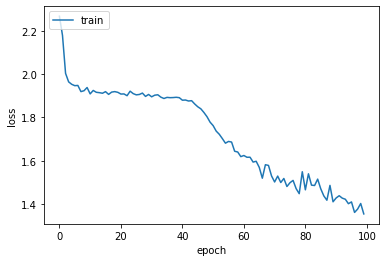

In [22]:
from tensorflow.keras.layers import Dense, LSTM

# 3. 모델 구성하기
model = Sequential()
# model.add(Dense(128, input_dim=4, activation='relu'))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(one_hot_vec_size, activation='softmax'))
model.add(LSTM(128, batch_input_shape = (1, 4, 1), stateful=True))
model.add(Dense(one_hot_vec_size, activation='softmax'))

# 4. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# history = LossHistory() # 손실 이력 객체 생성
# history.init()

# # 5. 모델 학습시키기
# model.fit(X_train, y_train, epochs=2000, batch_size=10, verbose=2, callbacks=[history])
hist = model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0)
    

# 6. 학습과정 살펴보기
# %matplotlib inline
import matplotlib.pyplot as plt

# plt.plot(history.losses)
plt.plot(hist.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()


In [23]:
# 7. 모델 평가하기
scores = model.evaluate(X_train, y_train, batch_size=1)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))


50/50 [==============================] - 0s 1ms/step - loss: 1.2880 - accuracy: 0.5200
accuracy: 52.00%


In [24]:
# 8. 모델 사용하기

pred_count = 50 # 최대 예측 개수 정의

# 한 스텝 예측

seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(X_train, batch_size=1)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", seq_out)

# 곡 전체 예측

seq_in = ['g8', 'e8', 'e4', 'f8']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 4, 1)) # batch_size, feature
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

print("full song prediction : ", seq_out)

one step prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'g8', 'g8', 'e8', 'e8', 'e8', 'e8', 'e8', 'd4', 'e8', 'e4', 'e8', 'e8', 'c8', 'd8', 'e8', 'g8', 'e8', 'e8', 'e4', 'f8', 'd8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'd4', 'c8', 'd8', 'd4', 'c8', 'd8', 'e8', 'g8', 'e8', 'e8', 'e4']
full song prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'g8', 'g8', 'e8', 'e8', 'e4', 'f8', 'd8', 'g8', 'e8', 'e8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'g8', 'g8', 'e8', 'e8', 'e4', 'f8', 'd8', 'g8', 'e8', 'e8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'g8', 'g8', 'e8', 'e8', 'e4', 'f8', 'd8', 'g8', 'e8', 'e8', 'e8', 'e4']


#Two Column

In [25]:
# 0. 사용할 패키지 불러오기
from tensorflow import keras
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import utils

# 랜덤시드 고정시키기
np.random.seed(5)

# 데이터셋 생성 함수
def seq2dataset(seq, window_size):
    dataset_X = []
    dataset_Y = []
    
    for i in range(len(seq)-window_size):
        
        subset = seq[i:(i+window_size+1)]
        
        for si in range(len(subset)-1):
            features = code2features(subset[si])            
            dataset_X.append(features)

        dataset_Y.append([code2idx[subset[window_size]]])
        
    return np.array(dataset_X), np.array(dataset_Y)

# 속성 변환 함수
def code2features(code):
    features = []
    features.append(code2scale[code[0]]/float(max_scale_value))
    features.append(code2length[code[1]])
    return features

# 1. 데이터 준비하기

# 코드 사전 정의

code2scale = {'c':0, 'd':1, 'e':2, 'f':3, 'g':4, 'a':5, 'b':6}
code2length = {'4':0, '8':1}

code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

max_scale_value = 6.0
    
# 시퀀스 데이터 정의
seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

# 2. 데이터셋 생성하기

x_train, y_train = seq2dataset(seq, window_size = 4)
print('before reshape : ',x_train.shape)
# 입력을 (샘플 수, 타임스텝, 특성 수)로 형태 변환
X_train = np.reshape(x_train, (50, 4, 2))
print('after reshape : ',X_train.shape)


before reshape :  (200, 2)
after reshape :  (50, 4, 2)


In [26]:
# x_train[3], x_train[5], y_train[3], y_train[5]

In [27]:
# num = 8
# X_train[num], X_train[num].shape, y_train[num], y_train[num].shape

In [28]:
# 라벨값에 대한 one-hot 인코딩 수행
y_train = utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is ", one_hot_vec_size)

one hot encoding vector size is  12


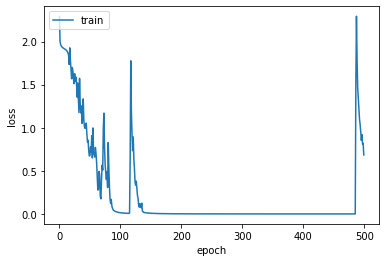

50/50 [==============================] - 0s 1ms/step - loss: 0.5933 - accuracy: 0.8000
accuracy: 80.00%


In [29]:

# 3. 모델 구성하기
model = Sequential()
model.add(LSTM(128, batch_input_shape = (1, 4, 2), stateful=True))
model.add(Dense(one_hot_vec_size, activation='softmax'))
    
# 4. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 5. 모델 학습시키기
num_epochs = 2000

hist = model.fit(X_train, y_train, epochs=500, batch_size=1, verbose=0, shuffle=False) # 50 is X.shape[0]
model.reset_states()
    
# 6. 학습과정 살펴보기
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# 7. 모델 평가하기
scores = model.evaluate(X_train, y_train, batch_size=1)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))



In [30]:
model.reset_states()
# 8. 모델 사용하기

pred_count = 50 # 최대 예측 개수 정의

# 한 스텝 예측

seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(X_train, batch_size=1)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", seq_out)

model.reset_states()

# 곡 전체 예측

seq_in = ['g8', 'e8', 'e4', 'f8']
seq_out = seq_in

seq_in_featrues = []

for si in seq_in:
    features = code2features(si)
    seq_in_featrues.append(features)
print(seq_in_featrues)

for i in range(pred_count):
    sample_in = np.array(seq_in_featrues)
    sample_in = np.reshape(sample_in, (1, 4, 2)) # 샘플 수, 타입스텝 수, 속성 수
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    
    features = code2features(idx2code[idx])
    seq_in_featrues.append(features)
    seq_in_featrues.pop(0)

model.reset_states()
    
print("full song prediction : ", seq_out)

one step prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'g8', 'd8', 'g8', 'g8', 'g8', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'g8', 'g8', 'e8', 'e8', 'e8', 'e8', 'd8', 'd8', 'g8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'd8', 'g8', 'g8', 'e8', 'e8', 'e4']
[[0.6666666666666666, 1], [0.3333333333333333, 1], [0.3333333333333333, 0], [0.5, 1]]
full song prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'g8', 'g8', 'e8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'g8', 'g8', 'e8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'g8', 'g8', 'e8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'g8', 'g8', 'e8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'g8', 'g8', 'e8', 'e8', 'e4', 'f8']
